# SQL-Based Analysis
- Explore trends in my Spotify listening data using SQL queries
- Focus on insights that are either unique to SQL or more efficient using SQL
- Highlights include longest listening days, genre and artist aggregations, and SQL-derived visualizations
- Demonstrates the value of structured querying for deeper, relational insights

In [28]:
import pandas as pd
import os
import json
import sqlite3

# Load all JSON streaming files
data_path = '../data/Spotify Extended Streaming History'
dfs = []

for file in os.listdir(data_path):
    if file.endswith('.json') and file != 'artist_genre_map.json':
        dfs.append(pd.read_json(os.path.join(data_path, file)))

df = pd.concat(dfs, ignore_index=True)
df.rename(columns={'master_metadata_album_artist_name': 'artist'}, inplace=True)

# Load genre map
with open(os.path.join(data_path, 'artist_genre_map.json'), 'r', encoding='utf-8') as f:
    genre_map = json.load(f)

# Assign genres
df['genre'] = df['artist'].map(lambda a: genre_map.get(a, ['Unknown'])[0] if genre_map.get(a) else 'Unknown')

# Drop unknown genres
df = df[df['genre'] != 'Unknown']
print(f"Cleaned dataset has {len(df):,} entries with valid genres.")

# Save to SQLite
conn = sqlite3.connect("spotify_clean.db")
df.to_sql("streaming", conn, if_exists="replace", index=False)
print("Database created: spotify_clean.db with table 'streaming'")

Cleaned dataset has 118,263 entries with valid genres.
Database created: spotify_clean.db with table 'streaming'


## Top Listening Days by Playtime  
Identify the days where I spent the most time listening to music by summing total minutes played per day.


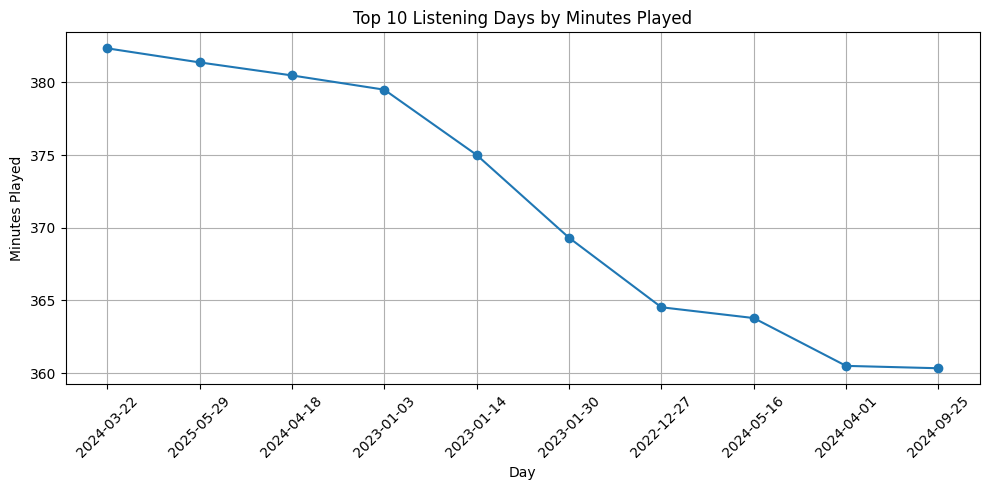

In [29]:
query = """
SELECT DATE(ts) as day, SUM(ms_played) / 60000.0 as minutes_played
FROM streaming
GROUP BY day
ORDER BY minutes_played DESC
LIMIT 10;
"""

top_days = pd.read_sql(query, conn)
top_days

## Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(top_days['day'], top_days['minutes_played'], marker='o')
plt.title("Top 10 Listening Days by Minutes Played")
plt.xlabel("Day")
plt.ylabel("Minutes Played")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


- The peak listening day was 2024-03-22 with approximately 383 minutes played.
- The lowest in the top 10 was 2024-09-25 at around 361 minutes.
- There is a gradual decline in minutes played over these top days, indicating variability in daily listening engagement.

## Listening Trends by Hour of Day
Analyzes my total listening minutes for each hour of the day to identify peak listening times.

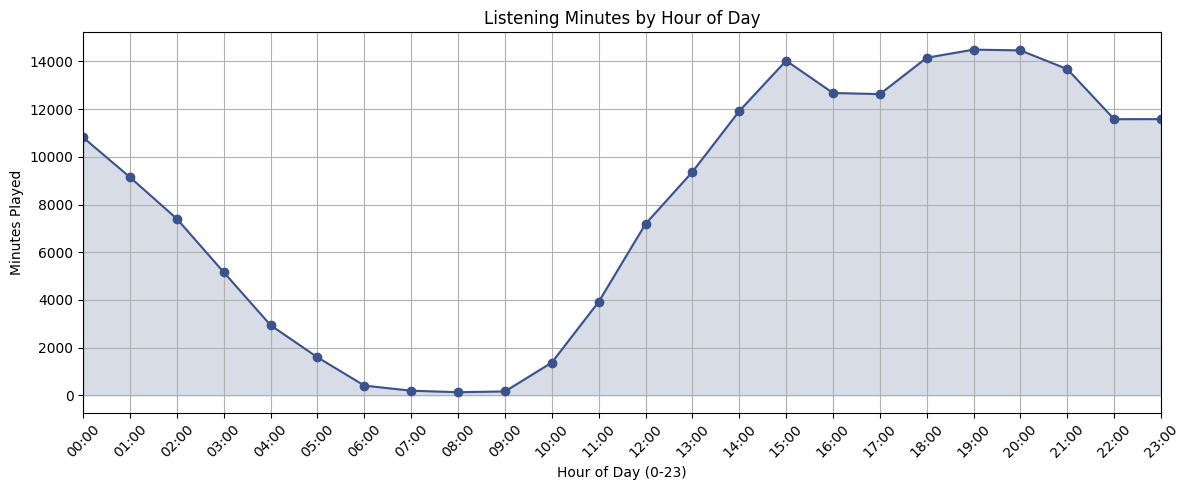

In [ ]:
query = """
SELECT CAST(strftime('%H', ts) AS INTEGER) AS hour,
       SUM(ms_played) / 60000.0 AS minutes_played
FROM streaming
GROUP BY hour
ORDER BY hour;
"""

hourly_trends = pd.read_sql(query, conn)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(hourly_trends['hour'], hourly_trends['minutes_played'], marker='o', linestyle='-', color=plt.cm.viridis(0.75))
plt.fill_between(hourly_trends['hour'], hourly_trends['minutes_played'], alpha=0.2, color=plt.cm.viridis(0.75))
plt.xticks(range(0, 24), [f"{h:02d}:00" for h in range(24)], rotation=45)
plt.xlim(0, 23)
plt.title("Listening Minutes by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Minutes Played")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


- Listening is highest from mid-afternoon through the evening, peaking around 7-8 PM with over 14,000 total minutes played.
- There’s a sharp drop-off in listening after midnight, hitting near-zero between about 6 AM and 9 AM.
- Listening starts to gradually rise again after 9 AM, with a noticeable increase from 10 AM onwards.
- The lowest engagement hours are the early morning hours (6 to 9 AM), indicating little music activity during typical waking-up hours.
- Listening engagement is strong during typical active hours (11 AM to 9 PM), showing you’re most engaged with music in the later part of the day.